In [24]:
import json 

# path to your JSONL file
path = "/Users/henry/CS230-Project/results/analysis_results-updated.jsonl"

samples = []
with open(path, "r") as f:
    for line in f:
        if line.strip():                     # skip blank lines
            sample = json.loads(line)        # parse one JSON object
            samples.append(sample)


In [25]:
import pandas as pd

# create pandas DataFrame
df = pd.DataFrame(samples)
# print(df.head())

## What is the distribution of frequencies of programs using types of calls?

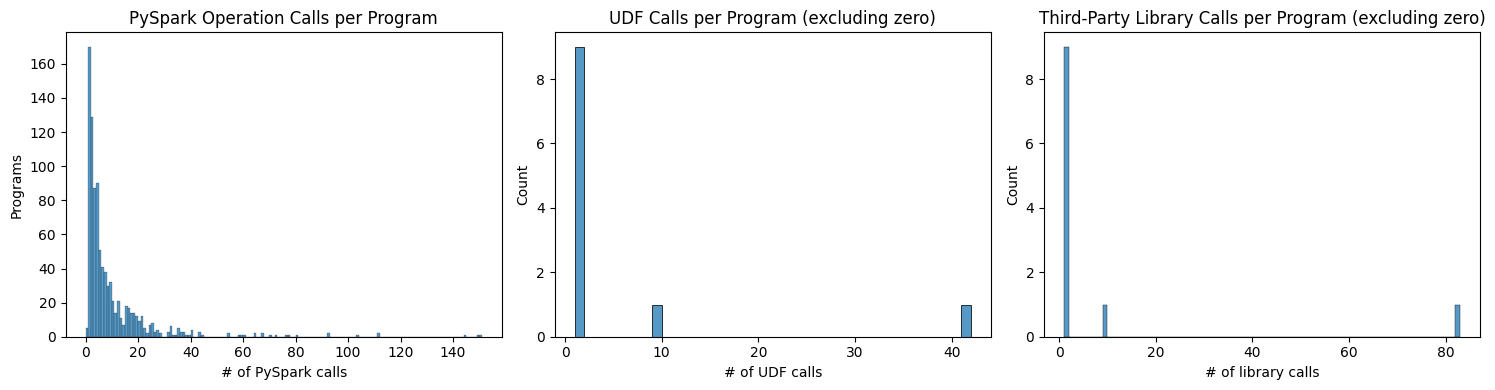

In [31]:
import pandas as pd
from itertools import chain

# Count raw occurrences per program (repo + path)
program_usage = (
    df.groupby(['repo_name', 'path'])
      .agg({
          'pyspark_ops': lambda x: sum(len(lst) for lst in x),
          'udfs':        lambda x: sum(len(lst) for lst in x),
          'third_party_libs': lambda x: sum(len(lst) for lst in x)
      })
      .rename(columns={
          'pyspark_ops': 'pyspark_ops_calls',
          'udfs': 'udf_calls',
          'third_party_libs': 'third_party_calls'
      })
      .reset_index()
)

program_usage['program_name'] = program_usage['repo_name'] + '/' + program_usage['path']

import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

sns.histplot(program_usage['pyspark_ops_calls'], bins=range(0, program_usage['pyspark_ops_calls'].max()+2), ax=axes[0])
axes[0].set_title('PySpark Operation Calls per Program')
axes[0].set_xlabel('# of PySpark calls')
axes[0].set_ylabel('Programs')

sns.histplot(program_usage['udf_calls'], bins=range(1, program_usage['udf_calls'].max()+2), ax=axes[1])
axes[1].set_title('UDF Calls per Program (excluding zero)')
axes[1].set_xlabel('# of UDF calls')

sns.histplot(program_usage['third_party_calls'], bins=range(1, program_usage['third_party_calls'].max()+2), ax=axes[2])
axes[2].set_title('Third-Party Library Calls per Program (excluding zero)')
axes[2].set_xlabel('# of library calls')

plt.tight_layout()
plt.show()

In [27]:
import pandas as pd
from itertools import chain

# group by program (repo + path)
programs = (
    df.groupby(['repo_name', 'path'])
      .agg({
          'pyspark_ops': lambda x: sorted(set(chain.from_iterable(x))),
          'udfs':        lambda x: sorted(set(chain.from_iterable(x))),
          'third_party_libs': lambda x: sorted(set(chain.from_iterable(x)))
      })
      .reset_index()
)

# derive flags and counts
programs['pyspark_ops_count'] = programs['pyspark_ops'].apply(len)
programs['udf_count'] = programs['udfs'].apply(len)
programs['third_party_count'] = programs['third_party_libs'].apply(len)
programs['program_name'] = programs['repo_name'] + '/' + programs['path']


## Diving into UDF usage

In [28]:
import pandas as pd
from collections import Counter
import os, glob

# df already loaded

rows = []

for _, row in df.iterrows():
    udfs = row.get("udfs", {})
    if not isinstance(udfs, dict):
        continue

    for udf_name, udf_meta in udfs.items():
        deps = udf_meta.get("third_party_dependencies", [])
        if not deps:
            continue

        for dep in deps:
            rows.append({"udf_name": udf_name, "third_party_dependencies": dep})

deps_df = pd.DataFrame(rows)

# classify dependencies as 'local' (relative or repo-local) vs 'third_party'
def is_local_dep(dep):
    if not isinstance(dep, str):
        return False
    dep = dep.strip()
    # leading-dot imports (e.g., .utils) are local/relative
    if dep.startswith('.'):
        return True
    # path-like or file-like references are likely local
    if dep.startswith('/') or '/' in dep or dep.endswith('.py'):
        return True
    # try to resolve a repo-local module file matching the dependency name
    candidate = dep.replace('.', '/')
    if os.path.exists(candidate + '.py') or os.path.exists(os.path.join(candidate, '__init__.py')):
        return True
    # do a recursive search for a matching module file in the repo
    matches = glob.glob(f'**/{dep}.py', recursive=True) + glob.glob(f'**/{dep}/__init__.py', recursive=True)
    return len(matches) > 0

if not deps_df.empty:
    deps_df['dependency_category'] = deps_df['third_party_dependencies'].apply(lambda d: 'local' if is_local_dep(d) else 'third_party')
else:
    deps_df['dependency_category'] = []

# counts per (udf, dependency)
udf_dep_counts = (
    deps_df
    .value_counts(["udf_name", "third_party_dependencies"])
    .reset_index(name="count")
)

# optional: total counts per dependency across all udfs, with categories
if deps_df.empty:
    dep_totals = pd.DataFrame(columns=["dependency", "count", "dependency_category"])
else:
    dep_totals = (
        deps_df
        .value_counts("third_party_dependencies")
        .reset_index(name="count")
        .rename(columns={"third_party_dependencies": "dependency"})
    )
    # attach category for each dependency
    dep_totals['dependency_category'] = dep_totals['dependency'].apply(lambda d: 'local' if is_local_dep(d) else 'third_party')

udf_dep_counts  # main result
# dep_totals    # if you want global popularity by dependency
# dep_totals.groupby('dependency_category').sum()  # totals per category

,udf_name,third_party_dependencies,count
0,func,numpy,3
1,_metaphone_udf_impl,jellyfish,1
2,h3_unidirectional_edge_is_valid,h3,1
3,hex_ranges,h3,1
4,hex_ranges,.utils,1
...,...,...,...
93,get_pentagon_indexes,h3,1
94,get_pentagon_indexes,.utils,1
95,get_origin_h3_index_from_unidirectional_edge,h3,1
96,get_origin_h3_index_from_unidirectional_edge,.utils,1


/var/folders/0b/9qm_3x6j3js13zvns_g2m5dc0000gn/T/ipykernel_22822/4249059322.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


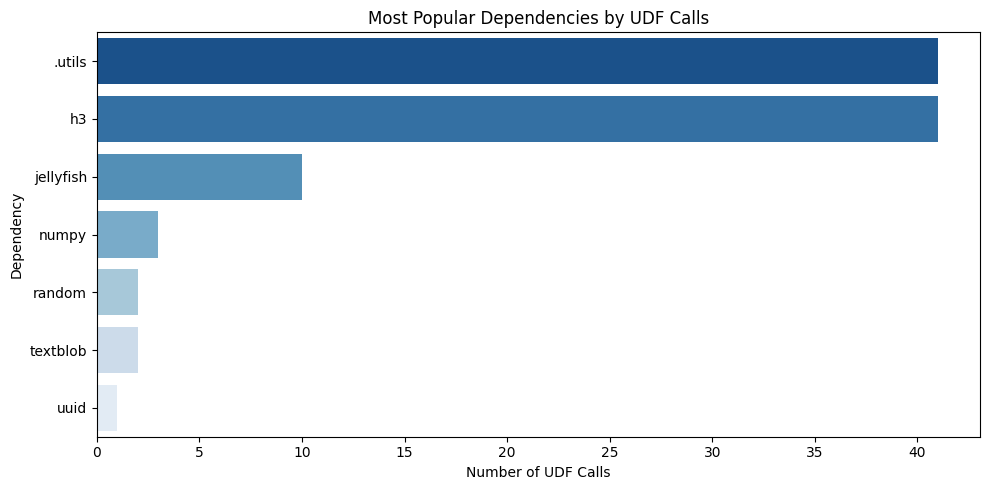

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# assume dep_totals from previous code
# (columns: dependency, count)

# sort and pick top N (e.g. 15)
top_n = dep_totals.sort_values("count", ascending=False).head(15)

plt.figure(figsize=(10,5))
sns.barplot(
    data=top_n,
    x="count",
    y="dependency",
    palette="Blues_r"
)
plt.title("Most Popular Dependencies by UDF Calls")
plt.xlabel("Number of UDF Calls")
plt.ylabel("Dependency")
plt.tight_layout()
plt.show()